In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.utils import np_utils,plot_model
from keras.optimizers import SGD, Adam
from keras.layers import Input,Flatten,Dense,Dropout, regularizers, LeakyReLU
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.
C:\Users\Ray\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Ray\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Ray\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Ray\Anaconda3\envs\tensorflow

In [2]:
row_col = 64

batch_size= 64
epochs = 30

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
X_train = [cv2.resize(i, (row_col,row_col))
        for i in X_train]
X_train = np.concatenate([arr[np.newaxis] for arr in X_train]).astype('float32')


X_test = [cv2.resize(i, (row_col,row_col))
        for i in X_test]
X_test = np.concatenate([arr[np.newaxis] for arr in X_test]).astype('float32')

x_train, x_test = X_train / 255.0, X_test / 255.0
y_train = np_utils.to_categorical(Y_train)
y_test = np_utils.to_categorical(Y_test)


x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                        test_size=0.2,random_state=0)

In [3]:
def load_model():
    base_network = VGG16(include_top=False, weights='imagenet', input_shape=(row_col ,row_col ,3))
 
    # 凍結預設的參數
    for layer in base_network.layers:
        layer.trainable = False
 
    # 接上自行定義的全連結層
    model = Flatten()(base_network.output)
    model = Dense(4096, name='fc1')(model)
    model = LeakyReLU(alpha=0.05)(model)
    model = Dropout(0.5)(model)
    
    model = Dense(4096, name='fc2',kernel_regularizer=regularizers.l2(0.01))(model)
    model = LeakyReLU(alpha=0.05)(model)
    model = Dropout(0.25)(model)  
                      
    model = Dense(10, activation='softmax',name='prediction')(model)
    model = Model(base_network.input, model, name='my_model')

    return model
# 載入模型
model = load_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)

In [4]:
print('Train Size:', x_train.shape)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001), 
              metrics=['accuracy'])
 
# 開始訓練
history = model.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    verbose=1,
                    epochs=epochs, 
                    batch_size=batch_size)

Train Size: (40000, 64, 64, 3)
Instructions for updating:
Use tf.cast instead.
Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 56s 1ms/step - loss: 3.1459 - acc: 0.5216 - val_loss: 1.5342 - val_acc: 0.6274
Epoch 2/30
40000/40000 [==============================] - 52s 1ms/step - loss: 1.6016 - acc: 0.6101 - val_loss: 1.5334 - val_acc: 0.6410
Epoch 3/30
40000/40000 [==============================] - 53s 1ms/step - loss: 1.5200 - acc: 0.6327 - val_loss: 1.4250 - val_acc: 0.6647
Epoch 4/30
40000/40000 [==============================] - 53s 1ms/step - loss: 1.4711 - acc: 0.6465 - val_loss: 1.4651 - val_acc: 0.6342
Epoch 5/30
40000/40000 [==============================] - 54s 1ms/step - loss: 1.4168 - acc: 0.6604 - val_loss: 1.3842 - val_acc: 0.6762
Epoch 6/30
40000/40000 [==============================] - 54s 1ms/step - loss: 1.3811 - acc: 0.6721 - val_loss: 1.4462 - val_acc: 0.6533
Epoch 7/30
40000/40000 [=========================

In [5]:
loss, accuracy = model.evaluate(x_test, y_test)
print('Test:')
print('Loss:', loss)
print('Accuracy:', accuracy) 

10000/10000 [==============================] - 9s 949us/step
Test:
Loss: 1.4923884553909301
Accuracy: 0.6985


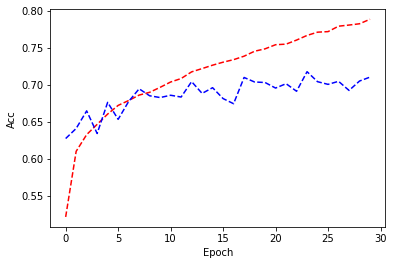

In [6]:
plt.plot(history.history['acc'], "r--")
plt.plot(history.history['val_acc'], "b--")
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.show()

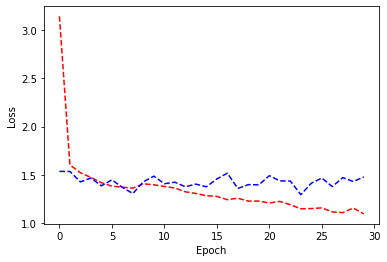

In [7]:
plt.plot(history.history['loss'], "r--",)
plt.plot(history.history['val_loss'], "b--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

In [9]:
#將OneHot轉換為字串
def Decoding_OneHot(onehot_data, data):
    Dec = []
    for i,true_num in enumerate(onehot_data):
        for index, num in enumerate(class_names):
            if index==true_num:
                Dec.append(num)
    return Dec


y_true = Decoding_OneHot(y_true, class_names)
y_pred = Decoding_OneHot(y_pred, class_names)

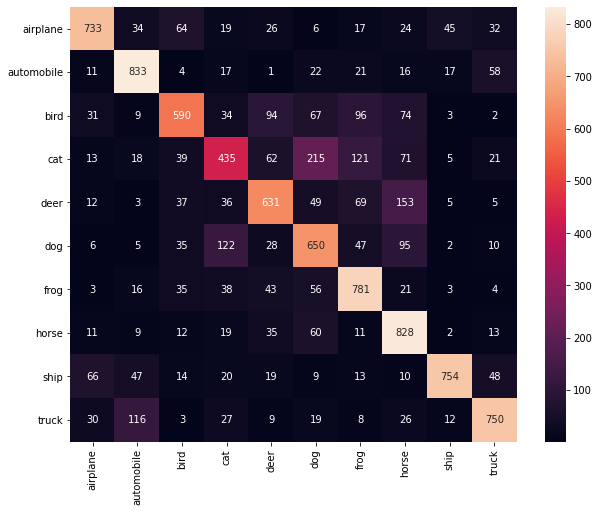

In [10]:
cm= confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='g')
plt.show()